In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation
import tensorflow.keras.utils as np_utils
from tqdm.auto import tqdm
import numpy as np
import os
import cv2
import random
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [3]:
path = '/content/drive/MyDrive/IA_PROJETO_FINAL'

In [4]:
# Alterei o batch_size para 64, e a dimensão geral das imagens para 64
batch_size = 64
epochs = 100
n_classes = 2
height = 64
width = 64

In [5]:
def obtem_imagens(path: str, tipo_grao: str, tipo_pasta: str, height: int, width: int):
  lista_imagens = []
  lista_rotulos = []

  caminho = os.path.join(path, tipo_grao, tipo_pasta)
  for image in tqdm(os.listdir(caminho)):
    img = cv2.imread(os.path.join(caminho, image))
    rotulo = 0 if tipo_grao == 'grao_quebrado' else 1

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (height, width))
    lista_imagens.append(img)
    lista_rotulos.append(rotulo)

  x = np.array(lista_imagens, dtype=np.float32)
  y = np.array(lista_rotulos, dtype=np.int32)
  y = y.reshape(-1, 1)

  return x, y

### Grao quebrado

In [6]:
grao_quebrado_teste_imgs, grao_quebrado_teste_rotulos = obtem_imagens(path, 'grao_quebrado', 'test', height, width)

  0%|          | 0/16 [00:00<?, ?it/s]

In [7]:
grao_quebrado_teste_imgs.shape

(16, 64, 64, 3)

In [8]:
grao_quebrado_treino_imgs, grao_quebrado_treino_rotulos = obtem_imagens(path, 'grao_quebrado', 'train', height, width)

  0%|          | 0/58 [00:00<?, ?it/s]

In [9]:
grao_quebrado_treino_imgs.shape

(58, 64, 64, 3)

### Grao inteiro

In [10]:
grao_inteiro_teste_imgs, grao_inteiro_teste_rotulos = obtem_imagens(path, 'graos_inteiros', 'test', height, width)

  0%|          | 0/22 [00:00<?, ?it/s]

In [11]:
grao_inteiro_teste_imgs.shape

(22, 64, 64, 3)

In [12]:
grao_inteiro_treino_imgs, grao_inteiro_treino_rotulos = obtem_imagens(path, 'graos_inteiros', 'train', height, width)

  0%|          | 0/96 [00:00<?, ?it/s]

In [13]:
grao_inteiro_treino_imgs.shape

(96, 64, 64, 3)

### Divisão de treino e teste

In [14]:
x_train = np.concatenate((grao_quebrado_treino_imgs, grao_inteiro_treino_imgs), axis=0)
x_test = np.concatenate((grao_quebrado_teste_imgs, grao_inteiro_teste_imgs), axis=0)

y_train = np.concatenate((grao_quebrado_treino_rotulos, grao_inteiro_treino_rotulos), axis=0)
y_test = np.concatenate((grao_quebrado_teste_rotulos, grao_inteiro_teste_rotulos), axis=0)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [16]:
print(x_train.shape, y_train.shape)

(123, 64, 64, 3) (123, 1)


In [17]:
print(x_test.shape, y_test.shape)

(38, 64, 64, 3) (38, 1)


In [18]:
print(x_val.shape, y_val.shape)

(31, 64, 64, 3) (31, 1)


### Data augmentation

In [19]:
def augment_np(image):
  # Flip horizontal e vertical
  image = tf.image.random_flip_left_right(image)
  if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_up_down(image)

  # Brilho, contraste, saturação
  #image = tf.image.random_brightness(image, max_delta=0.15)
  #image = tf.image.random_contrast(image, 0.85, 1.15)
  #image = tf.image.random_saturation(image, 0.85, 1.15)

  # Mudança de matiz (leve)
  image = tf.image.random_hue(image, max_delta=0.05)

  # Inversão de cor (raro)
  if tf.random.uniform(()) > 0.9:
      image = tf.bitwise.invert(tf.cast(image, tf.uint8))
      image = tf.cast(image, tf.float32)

  # Ruído leve (raramente)
  if tf.random.uniform(()) > 0.85:
      noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=5.0)
      image = image + noise

  # Resize final pra garantir shape fixo
  image = tf.image.resize(image, [height, width])
  image = tf.clip_by_value(image, 0.0, 255.0)

  return image


x_train_final = x_train
y_train_final = y_train

for i in tqdm(range(10), desc="Aplicando data augmentation"):
  x_augmented = []
  y_augmented = []

  for i in range(len(x_train)):
      img = x_train[i]
      label = y_train[i]
      img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
      img_aug = augment_np(img_tensor)
      x_augmented.append(img_aug.numpy())
      y_augmented.append(label)

  x_augmented = np.array(x_augmented, dtype=np.float32)
  y_augmented = np.array(y_augmented, dtype=np.int32)

  x_train_final = np.concatenate([x_train_final, x_augmented], axis=0)
  y_train_final = np.concatenate([y_train_final, y_augmented], axis=0)

print("x_train_final:", x_train_final.shape)
print("y_train_final:", y_train_final.shape)

Aplicando data augmentation:   0%|          | 0/10 [00:00<?, ?it/s]

x_train_final: (1353, 64, 64, 3)
y_train_final: (1353, 1)


In [20]:
y_train_final = y_train_final.reshape(-1, 1)

In [21]:
x_train = x_train_final
y_train = y_train_final

### Normalização

In [22]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_val /= 255
x_test /= 255

In [23]:
print(y_train.shape, x_train.shape)

(1353, 1) (1353, 64, 64, 3)


### Conversão dos rótulos

In [24]:
y_train = np_utils.to_categorical(y_train, n_classes)
y_val = np_utils.to_categorical(y_val, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)

In [25]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(np.unique(np.argmax(y_train, axis=1), return_counts=True))
print(np.unique(np.argmax(y_val, axis=1), return_counts=True))

(1353, 64, 64, 3) (1353, 2)
(31, 64, 64, 3) (31, 2)
(array([0, 1]), array([506, 847]))
(array([0, 1]), array([12, 19]))


### Treinamento do modelo

In [26]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (5,5), padding='same', input_shape=(height, width, 3))) # (5, 5) ou (3, 3)
    model.add(MaxPooling2D(2,2))
    # model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(MaxPooling2D(2,2))
    # model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation='sigmoid'))

    return model

In [27]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [28]:
# Aqui alterei a taxa de aprendizado para 5 elevado a -7, mais alto que isso gera overfitting, e mais baixo gera underfitting.

model = create_model()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-7),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
history = model.fit(
          x_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          validation_data = (x_val, y_val),
          validation_batch_size = batch_size,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.4664 - loss: 0.7063 - val_accuracy: 0.4194 - val_loss: 0.6943
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.5216 - loss: 0.6936 - val_accuracy: 0.5161 - val_loss: 0.6854
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step - accuracy: 0.5786 - loss: 0.6785 - val_accuracy: 0.6452 - val_loss: 0.6781
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.5920 - loss: 0.6737 - val_accuracy: 0.6774 - val_loss: 0.6725
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.6419 - loss: 0.6629 - val_accuracy: 0.6129 - val_loss: 0.6673
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - accuracy: 0.6404 - loss: 0.6612 - val_accuracy: 0.6129 - val_loss: 0.6625
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - accuracy: 0.6288 - loss: 0.6578 - val_accuracy: 0.6129 - val_loss: 0.6584
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.6650 - loss: 0.6477 - val_a

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,209,096 (12.24 MB)

 Trainable params: 1,069,698 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,139,398 (8.16 MB)

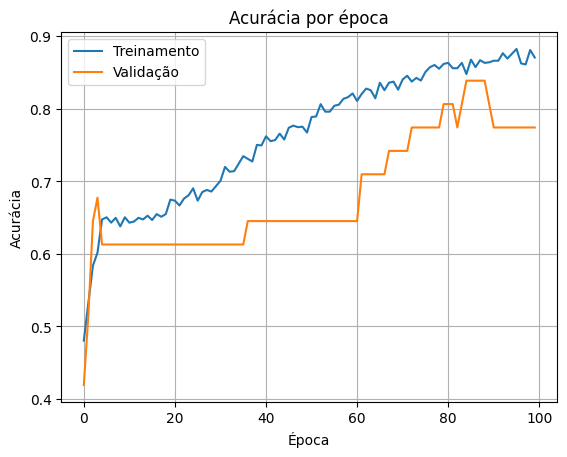

In [31]:
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

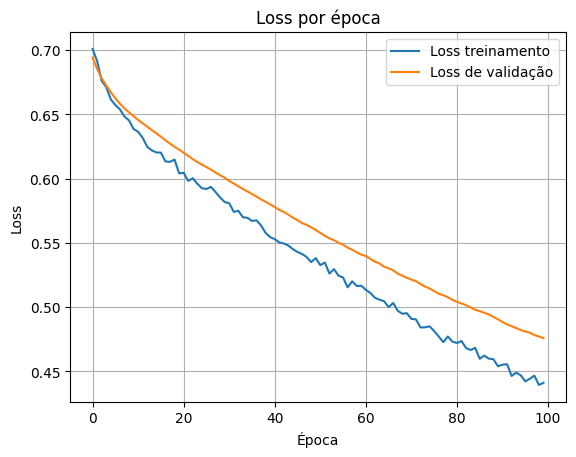

In [32]:
plt.plot(history.history['loss'], label='Loss treinamento')
plt.plot(history.history['val_loss'], label='Loss de validação')
plt.title('Loss por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_true_classes, y_pred_classes, target_names=['Quebrado', 'Inteiro']))

              precision    recall  f1-score   support

    Quebrado       1.00      0.88      0.93        16
     Inteiro       0.92      1.00      0.96        22

    accuracy                           0.95        38
   macro avg       0.96      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38



In [35]:
print(f"Acurácia: {accuracy_score(y_true_classes, y_pred_classes)}")

Acurácia: 0.9473684210526315
